In [1]:
# Import and setup
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import gc
%matplotlib inline

In [2]:
class DfTransformer:
    def __init__(self):
        self.mean_rankpoints = None
        self.mean_killpoints = None
        self.mean_winpoints = None
        self.df_test_meta = None
    
    def transform_train(self, df):
        # Replace None values of rankPoints with mean
        col_rankpoints = df['rankPoints']
        col_rankpoints = col_rankpoints.loc[col_rankpoints > 1e-4]
        self.mean_rankpoints = col_rankpoints.mean()
        # print('The mean of non-none rankPoints is %.3f' % mean_rankpoints)
        df.loc[df['rankPoints'] < 1e-4, 'rankPoints'] = self.mean_rankpoints
        
        # Replace None values of killPoints with mean
        col_killpoints = df['killPoints']
        col_killpoints = col_killpoints.loc[col_killpoints > 1e-4]
        self.mean_killpoints = col_killpoints.mean()
        # print('The mean of non-none killPoints is %.3f' % mean_killpoints)
        df.loc[df['killPoints'] < 1e-4, 'killPoints'] = self.mean_killpoints
        
        # Replace None values of winPoints with mean
        col_winpoints = df['winPoints']
        col_winpoints = col_winpoints.loc[col_winpoints > 1e-4]
        self.mean_winpoints = col_winpoints.mean()
        # print('The mean of non-none winPoints is %.3f' % mean_winpoints)
        df.loc[df['winPoints'] < 1e-4, 'winPoints'] = self.mean_winpoints
        
        # Feature engineering
        return self.feature_engineering(df, is_train=True)
    
    def transform_test(self, df):
        return self.transform_test_directly(df, self.mean_rankpoints,
                                            self.mean_killpoints, self.mean_winpoints)
    
    def transform_test_directly(self, df, mean_rankpoints, mean_killpoints, mean_winpoints):
        # Replace None values of rankPoints, killPoints, winPoints
        df.loc[df['rankPoints'] < 1e-4, 'rankPoints'] = mean_rankpoints
        df.loc[df['killPoints'] < 1e-4, 'killPoints'] = mean_killpoints
        df.loc[df['winPoints'] < 1e-4, 'winPoints'] = mean_winpoints
        
        # Feature engineering
        return self.feature_engineering(df, is_train=False)
    
    def transform_prediction(self, df_meta, y_predicted):
        df_y = df_meta.copy()
        df_y['winPlacePerc'] = y_predicted
        return (self.df_test_meta.merge(df_y, on=['matchId', 'groupId'], how='left'))[['Id', 'winPlacePerc']]
    
    def feature_engineering(self, df, is_train=True):
        # Add hand-engineered features
        df_walkDistance = df['walkDistance'] + 5
        df['heals_over_dist'] = df['heals'] / df_walkDistance
        df['boosts_over_dist'] = df['boosts'] / df_walkDistance
        df['kills_over_dist'] = df['kills'] / df_walkDistance
        df['headshots_over_dist'] = df['headshotKills'] / df_walkDistance
        df['killStreaks_over_dist'] = df['killStreaks'] / df_walkDistance
        df['damageDealt_over_dist'] = df['damageDealt'] / df_walkDistance
        df['dbnos_over_dist'] = df['DBNOs'] / df_walkDistance
        df['weapons_over_dist'] = df['weaponsAcquired'] / df_walkDistance
        df['revives_over_dist'] = df['revives'] / df_walkDistance
        df_walkDistance = None
        df_kills = df['kills'] + 0.001
        df['headshots_over_kills'] = df['headshotKills'] / df_kills
        df['killStreaks_over_kills'] = df['killStreaks'] / df_kills
        df_kills = None
        df['teamwork'] = df['assists'] + df['revives']
        df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']
        df['items'] = df['heals'] + df['boosts']
        df['skills'] = df['headshotKills'] + df['roadKills']
        # df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace'] # No improvement
        
        features = df.columns.tolist()
        features.remove('Id')
        features.remove('groupId')
        features.remove('matchId')
        features.remove('matchType')
        if is_train: features.remove('winPlacePerc')
            
        # Define method to map column names (adding suffix)
        def map_col_names(df, features, suffix):
            col_name_dict = {}
            for name in features:
                col_name_dict[name] = name + suffix
            return df.rename(columns=col_name_dict)
            
        # Add group mean and group mean rank in match
        group_by = df.groupby(['matchId','groupId'])
        group_by_features = group_by[features]
        df_agg = group_by_features.agg('mean')
        df_agg_rank = df_agg.groupby('matchId')[features].rank(pct=True).reset_index()
        df_out = df_agg.reset_index().merge(df_agg_rank, on=['matchId', 'groupId'], how='left',
                                            suffixes=["_groupMean", "_groupMeanRank"])

        # Add group max and group max rank in match
        df_agg = group_by_features.agg('max')
        df_agg_rank = df_agg.groupby('matchId')[features].rank(pct=True).reset_index()
        df_agg = df_agg.reset_index().merge(df_agg_rank, on=['matchId', 'groupId'], how='left',
                                            suffixes=["_groupMax", "_groupMaxRank"])
        df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')

        # Add group min and group min rank in match
        df_agg = group_by_features.agg('min')
        df_agg_rank = df_agg.groupby('matchId')[features].rank(pct=True).reset_index()
        df_agg = df_agg.reset_index().merge(df_agg_rank, on=['matchId', 'groupId'], how='left',
                                            suffixes=["_groupMin", "_groupMinRank"])
        df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')
        
        # Add group sum and group sum rank in match
        df_agg = group_by_features.agg('sum')
        df_agg_rank = df_agg.groupby('matchId')[features].rank(pct=True).reset_index()
        df_agg = df_agg.reset_index().merge(df_agg_rank, on=['matchId', 'groupId'], how='left',
                                            suffixes=["_groupSum", "_groupSumRank"])
        df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')
        
        # Add group std
        df_out = df_out.merge(group_by_features.agg('std').reset_index(), on=['matchId', 'groupId'], how='left')
        df_out = df_out.fillna(0)  # zero divisor is present for single player group
        df_out = map_col_names(df_out, features, '_groupStd')
        group_by_features = None
        
        # Add group size
        df_agg = group_by.size().to_frame('groupSize').reset_index()
        df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')

        # Add target if for training
        if is_train:
            df_agg = group_by[['winPlacePerc']].first().reset_index()
            df_out = df_out.merge(df_agg, on=['matchId', 'groupId'], how='left')
            
        # Add match mean
        group_by = df.groupby(['matchId'])
        group_by_features = group_by[features]
        df_out = df_out.merge(group_by_features.agg('mean').reset_index(), on=['matchId'], how='left')
        df_out = map_col_names(df_out, features, '_matchMean')
        
        # Add match max
        df_out = df_out.merge(group_by_features.agg('max').reset_index(), on=['matchId'], how='left')
        df_out = map_col_names(df_out, features, '_matchMax')
        
        # Add match min
        df_out = df_out.merge(group_by_features.agg('min').reset_index(), on=['matchId'], how='left')
        df_out = map_col_names(df_out, features, '_matchMin')
        
        # Add match sum
        df_out = df_out.merge(group_by_features.agg('sum').reset_index(), on=['matchId'], how='left')
        df_out = map_col_names(df_out, features, '_matchSum')
        
        # Add match std
        df_out = df_out.merge(group_by_features.agg('std').reset_index(), on=['matchId'], how='left')
        df_out = df_out.fillna(0)
        df_out = map_col_names(df_out, features, '_matchStd')
        group_by_features = None
        
        # Add match size
        df_agg = group_by['groupId'].nunique().to_frame('matchSize').reset_index()
        df_out = df_out.merge(df_agg, on=['matchId'], how='left')

        # Add encoded matchType (no improvement)
        # df_agg = group_by['matchType'].first().reset_index()
        # df_out = df_out.merge(df_agg, on=['matchId'], how='left')
        # df_out = pd.get_dummies(df_out, columns=['matchType']) # Ont-hot encoding
        # df_out['matchType'] = df_out['matchType'].astype('category').cat.codes # Label encoding
        
        # Keep metadata of df_test for later restoring individual prediction
        if not is_train:
            self.df_test_meta = df[['Id', 'matchId', 'groupId']]
        
        # Return: features, metadata, weights
        return df_out.drop(columns=['matchId', 'groupId']),\
               df_out[['matchId', 'groupId']],\
               df_out['groupSize'].values

In [3]:
# Read test data
df_test = pd.read_csv('test_V2.csv', nrows=None)
print(df_test.shape)
df_test.head()

(1934174, 28)


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.00,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,0,2,1,361.90,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,0,0,0,0.00,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,0,0,0,0.00,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,0,3,1,60.06,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [4]:
# Preprocess data
df_transformer = DfTransformer()
mean_rankpoints = 1494.34089
mean_killpoints = 1253.6821744
mean_winpoints = 1505.542888

df_test, df_test_meta, _ = df_transformer.transform_test_directly(
    df_test, mean_rankpoints, mean_killpoints, mean_winpoints)

In [5]:
# Get X and y
X_test = df_test.values
df_test = None
print(X_test.shape)
gc.collect()

(886238, 548)


158

In [6]:
# Standardize
from sklearn.preprocessing import StandardScaler

df_scaler = pd.read_csv('training_scaler.csv')
print(df_scaler.shape)

scaler = StandardScaler()
scaler.scale_ = df_scaler['scale'].values
scaler.mean_ = df_scaler['mean'].values
scaler.var_ = df_scaler['var'].values
df_scaler = None

X_test = scaler.transform(X_test)

(548, 3)


In [7]:
# Load models
from joblib import load
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from keras.models import load_model

lr = load('LR.joblib')
lg = lgb.Booster(model_file='LightGBM_Model.txt')
nn = load_model('NN_Model.h5')

stacking_model = lgb.Booster(model_file='Stacking_Model.txt')

models = [lr, lg, nn]

Using TensorFlow backend.


In [8]:
# define method to build new dataset for stacking-level model
def build_stacking_dataset(models, X, df_meta, is_train=True):
    # Load and preprocess original training set
    df = None
    if is_train:
        df = pd.read_csv('train_V2.csv')
    else:
        df = pd.read_csv('test_V2.csv')
    df = df.dropna()
    # Fill out None values
    mean_rankpoints = 1494.34089
    mean_killpoints = 1253.6821744
    mean_winpoints = 1505.542888
    df.loc[df['rankPoints'] < 1e-4, 'rankPoints'] = mean_rankpoints
    df.loc[df['killPoints'] < 1e-4, 'killPoints'] = mean_killpoints
    df.loc[df['winPoints'] < 1e-4, 'winPoints'] = mean_winpoints
    
    # Add predictions to original training set
    for idx, model in enumerate(models):
        df_intermediate = df_meta.copy()
        df_intermediate['pred_' + str(idx)] = model.predict(X)
        df = df.merge(df_intermediate, on=['matchId', 'groupId'], how='left')
    
    if is_train:
        y = df['winPlacePerc'].values
        df = df.drop(columns=['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc'])
        return df.values, df.columns, y
    else:
        ids = df['Id']
        df = df.drop(columns=['Id', 'groupId', 'matchId', 'matchType'])
        return df.values, df.columns, ids

In [9]:
# Build stacking dataset
X_test, feature_name, ids = build_stacking_dataset(models, X_test, df_test_meta, is_train=False)

In [10]:
# Get Prediction
df_predicted = pd.DataFrame()
df_predicted['Id'] = ids
df_predicted['winPlacePerc'] = stacking_model.predict(X_test)
df_predicted.to_csv('submission.csv', index=False)

In [11]:
# Define method to plot feature importance
def plot_feature_importance(feature_importance, feature_name):
    idx_sorted = np.argsort(feature_importance)
    importance_sorted = feature_importance[idx_sorted]
    name_sorted = [feature_name[i] for i in idx_sorted]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.barh(np.arange(feature_importance.size), importance_sorted, tick_label=name_sorted)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

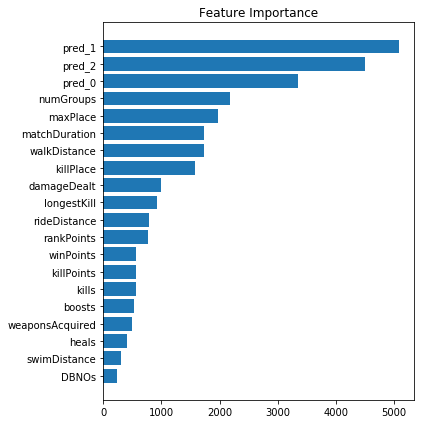

In [12]:
# Plot feature importance
topK = 20
feature_importance = stacking_model.feature_importance() # Number of splits
idx_sorted = np.argsort(feature_importance)
idx_topK = idx_sorted[-1:-topK-1:-1]

plot_feature_importance(feature_importance[idx_topK], feature_name[idx_topK].tolist())